In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick


In [36]:

# Set the style for the plots
plt.style.use('ggplot')
sns.set_palette("Set2")

# Define function to read the Excel file
def read_hotel_data(file_path):
    """Read the hotel survey data from Excel file."""
    return pd.read_excel("Raw_Data.xlsx")

In [38]:
# Define function to process the data
def process_survey_data(df):
    """Process the survey data to extract check-in and check-out responses."""
    # Define the 11 possible options
    options = [
        "Comfortable and Clean Rooms",
        "Delicious Breakfast",
        "Fast and Reliable Wi-Fi",
        "Friendly and Helpful Staff",
        "Quiet and Restful Environment",
        "Modern Fitness Facilities",
        "Family-Friendly Services",
        "Business Amenities",
        "Easy Parking & Check-in",
        "Stylish Interior Design",
        "Reservation & Communication"
    ]
    
    # Initialize dictionaries to count occurrences
    check_in_counts = {option: 0 for option in options}
    check_out_counts = {option: 0 for option in options}
    
    # Initialize lists to store individual responses
    check_in_responses = []
    check_out_responses = []
    
    # Process each customer's responses
    for _, row in df.iterrows():
        check_in_text = row["Check-In Questionnaire: What persuaded you to choose our hotel for your stay?"]
        check_out_text = row["Check-Out Questionnaire: What impressed you the most during your stay?"]

        check_in_items = check_in_text.split("; ") if pd.notnull(check_in_text) else []
        check_out_items = check_out_text.split("; ") if pd.notnull(check_out_text) else []

        
        check_in_responses.append(check_in_items)
        check_out_responses.append(check_out_items)
        
        # Count occurrences
        for item in check_in_items:
            if item in check_in_counts:
                check_in_counts[item] += 1
        
        for item in check_out_items:
            if item in check_out_counts:
                check_out_counts[item] += 1
    
    # Create a DataFrame for feature counts and percentages
    feature_data = []
    total_customers = len(df)
    
    for option in options:
        check_in_count = check_in_counts[option]
        check_out_count = check_out_counts[option]
        check_in_percent = (check_in_count / total_customers) * 100
        check_out_percent = (check_out_count / total_customers) * 100
        
        feature_data.append({
            'Feature': option,
            'Check_In_Count': check_in_count,
            'Check_Out_Count': check_out_count,
            'Check_In_Percent': check_in_percent,
            'Check_Out_Percent': check_out_percent,
            'Gap': check_out_percent - check_in_percent
        })
    
    features_df = pd.DataFrame(feature_data)
    
    # Calculate continuation rates
    continuation_data = []
    
    for option in options:
        mentioned_at_check_in = 0
        mentioned_at_both = 0
        
        for i in range(len(check_in_responses)):
            if option in check_in_responses[i]:
                mentioned_at_check_in += 1
                if option in check_out_responses[i]:
                    mentioned_at_both += 1
        
        continuation_rate = (mentioned_at_both / mentioned_at_check_in * 100) if mentioned_at_check_in > 0 else 0
        
        continuation_data.append({
            'Feature': option,
            'Mentioned_At_Check_In': mentioned_at_check_in,
            'Mentioned_At_Both': mentioned_at_both,
            'Continuation_Rate': continuation_rate
        })
    
    continuation_df = pd.DataFrame(continuation_data)
    
    # Calculate customer segments
    segments = {
        'higher_expectations': 0,  # More at check-in than check-out
        'lower_expectations': 0,   # More at check-out than check-in
        'same_different': 0,       # Same count but different items
        'same_same': 0             # Same count and same items
    }
    
    for i in range(len(check_in_responses)):
        check_in_count = len(check_in_responses[i])
        check_out_count = len(check_out_responses[i])
        
        if check_in_count > check_out_count:
            segments['higher_expectations'] += 1
        elif check_in_count < check_out_count:
            segments['lower_expectations'] += 1
        else:
            # Same count, check if items are the same
            same_items = all(item in check_out_responses[i] for item in check_in_responses[i]) and \
                        all(item in check_in_responses[i] for item in check_out_responses[i])
            
            if same_items:
                segments['same_same'] += 1
            else:
                segments['same_different'] += 1
    
    # Calculate average selections
    total_check_in = sum(len(resp) for resp in check_in_responses)
    total_check_out = sum(len(resp) for resp in check_out_responses)
    
    avg_selections = {
        'check_in': total_check_in / len(df),
        'check_out': total_check_out / len(df)
    }
    
    # Calculate disappointments and pleasant surprises
    disappointments = {option: 0 for option in options}
    pleasant_surprises = {option: 0 for option in options}
    
    for i in range(len(check_in_responses)):
        for item in check_in_responses[i]:
            if item in options and item not in check_out_responses[i]:
                disappointments[item] += 1
        
        for item in check_out_responses[i]:
            if item in options and item not in check_in_responses[i]:
                pleasant_surprises[item] += 1
    
    # Create disappointments and surprises DataFrames
    disappointments_df = pd.DataFrame([
        {'Feature': option, 'Count': count, 'Percentage': (count / check_in_counts[option] * 100) if check_in_counts[option] > 0 else 0}
        for option, count in disappointments.items()
    ])
    
    surprises_df = pd.DataFrame([
        {'Feature': option, 'Count': count}
        for option, count in pleasant_surprises.items()
    ])
    
    return {
        'features_df': features_df,
        'continuation_df': continuation_df,
        'segments': segments,
        'avg_selections': avg_selections,
        'disappointments_df': disappointments_df,
        'surprises_df': surprises_df,
        'total_customers': total_customers
    }



In [40]:
# Function to plot expectation vs. experience gap
def plot_expectation_gap(features_df):
    """Create a horizontal bar chart showing the gap between expectations and experiences."""
    # Sort by check-in percentage
    sorted_df = features_df.sort_values(by='Check_In_Percent', ascending=False)
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    
    # Plot horizontal bars
    y_pos = np.arange(len(sorted_df))
    plt.barh(y_pos - 0.2, sorted_df['Check_In_Percent'], height=0.4, label='Expected (Check-In)')
    plt.barh(y_pos + 0.2, sorted_df['Check_Out_Percent'], height=0.4, label='Impressed (Check-Out)')
    
    # Add feature names on y-axis
    plt.yticks(y_pos, sorted_df['Feature'])
    
    # Add percentage on x-axis
    plt.xlabel('Percentage of Guests (%)')
    plt.xlim(0, 100)
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add title and legend
    plt.title('Guest Expectation vs. Experience Gap', fontsize=16, pad=20)
    plt.legend(loc='upper right')
    
    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Tight layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('expectation_gap_chart.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    # Calculate and return the top 5 gaps
    sorted_df['Absolute_Gap'] = abs(sorted_df['Gap'])
    top_gaps = sorted_df.sort_values(by='Absolute_Gap', ascending=False).head(5)
    
    return top_gaps



In [42]:
# Function to plot continuation rates
def plot_continuation_rates(continuation_df):
    """Create a horizontal bar chart showing the continuation rates for each feature."""
    # Sort by continuation rate
    sorted_df = continuation_df.sort_values(by='Continuation_Rate', ascending=False)
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    
    # Define color mapping based on continuation rate
    def get_bar_color(rate):
        if rate >= 75:
            return "green"
        elif rate >= 50:
            return "gold"
        elif rate >= 25:
            return "orange"
        else:
            return "red"
    
    # Plot horizontal bars with color coding
    bar_colors = [get_bar_color(rate) for rate in sorted_df['Continuation_Rate']]
    bars = plt.barh(sorted_df['Feature'], sorted_df['Continuation_Rate'], color=bar_colors)
    
    # Add percentage on x-axis
    plt.xlabel('Continuation Rate (%)')
    plt.xlim(0, 100)
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add reference line at 50%
    plt.axvline(x=50, color='grey', linestyle='--', alpha=0.5)
    
    # Add title
    plt.title('Feature Expectation Fulfillment Rates', fontsize=16, pad=20)
    plt.suptitle('Percentage of guests who were impressed by a feature after expecting it', 
                 fontsize=12, y=0.92)
    
    # Add values at the end of each bar
    for i, v in enumerate(sorted_df['Continuation_Rate']):
        plt.text(v + 1, i, f"{v:.1f}%", va='center')
    
    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Tight layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('continuation_rates_chart.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    # Return the top and bottom features
    top_features = sorted_df.head(2)
    bottom_features = sorted_df.tail(3)
    critical_features = sorted_df[sorted_df['Feature'].isin(['Comfortable and Clean Rooms', 'Friendly and Helpful Staff'])]
    
    return {'top': top_features, 'bottom': bottom_features, 'critical': critical_features}



In [44]:
# Function to plot customer experience patterns
def plot_experience_patterns(segments, avg_selections, total_customers):
    """Create charts showing customer experience patterns."""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Prepare data for the pie chart
    segment_labels = [
        f"Higher Expectations ({segments['higher_expectations']/total_customers*100:.1f}%)",
        f"Lower Expectations ({segments['lower_expectations']/total_customers*100:.1f}%)",
        f"Same Count, Different Items ({segments['same_different']/total_customers*100:.1f}%)",
        f"Same Count, Same Items ({segments['same_same']/total_customers*100:.1f}%)"
    ]
    segment_values = [
        segments['higher_expectations'],
        segments['lower_expectations'],
        segments['same_different'],
        segments['same_same']
    ]
    segment_colors = ['#ef4444', '#3b82f6', '#f97316', '#22c55e']
    
    # Plot the pie chart
    ax1.pie(segment_values, labels=segment_labels, colors=segment_colors, autopct='%1.1f%%', 
            startangle=90, explode=[0.05, 0.05, 0.05, 0.05], shadow=True)
    ax1.set_title('Guest Experience Types', fontsize=14)
    
    # Prepare data for the bar chart
    selection_labels = ['Check-In', 'Check-Out']
    selection_values = [avg_selections['check_in'], avg_selections['check_out']]
    
    # Plot the bar chart
    bars = ax2.bar(selection_labels, selection_values, color=['#8884d8', '#82ca9d'])
    ax2.set_title('Average Features Selected', fontsize=14)
    ax2.set_ylim(0, 6)
    ax2.set_ylabel('Number of Features')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    # Add the gap information
    gap = avg_selections['check_in'] - avg_selections['check_out']
    percent_fewer = (gap / avg_selections['check_in']) * 100
    ax2.text(0.5, 0.05, f"Gap: {gap:.2f} features\n({percent_fewer:.1f}% fewer at check-out)",
             horizontalalignment='center', verticalalignment='bottom',
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('experience_patterns_chart.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
    
    return {
        'segments_data': dict(zip(segment_labels, segment_values)),
        'avg_selections': avg_selections,
        'gap_percent': percent_fewer
    }



In [50]:
# Main function to run the analysis
def analyze_hotel_data(file_path):
    """Main function to run the complete hotel data analysis."""
    # Read the data
    # print("Reading hotel survey data...")
    print("============================================================================================= 1")
    df = read_hotel_data(file_path)
    
    # Process the data
    # print("Processing survey data...")
    print("============================================================================================= 2")
    results = process_survey_data(df)
    
    # Display basic statistics
    print("\n===== BASIC STATISTICS =====")
    print(f"Total number of customers: {results['total_customers']}")
    print(f"Average selections at check-in: {results['avg_selections']['check_in']:.2f}")
    print(f"Average selections at check-out: {results['avg_selections']['check_out']:.2f}")
    
    # Display segment information
    print("\n===== CUSTOMER SEGMENTS =====")
    for segment, count in results['segments'].items():
        percentage = (count / results['total_customers']) * 100
        print(f"{segment.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
    
    # Display top features by check-in percentage
    print("\n===== TOP FEATURES BY CHECK-IN PERCENTAGE =====")
    top_check_in = results['features_df'].sort_values(by='Check_In_Percent', ascending=False).head(5)
    for _, row in top_check_in.iterrows():
        print(f"{row['Feature']}: {row['Check_In_Percent']:.1f}% at check-in, {row['Check_Out_Percent']:.1f}% at check-out, Gap: {row['Gap']:.1f}%")
    
    # Display top continuation rates
    print("\n===== TOP FEATURES BY CONTINUATION RATE =====")
    top_continuation = results['continuation_df'].sort_values(by='Continuation_Rate', ascending=False).head(5)
    for _, row in top_continuation.iterrows():
        print(f"{row['Feature']}: {row['Continuation_Rate']:.1f}% continuation rate")
    
    # Display bottom continuation rates
    print("\n===== BOTTOM FEATURES BY CONTINUATION RATE =====")
    bottom_continuation = results['continuation_df'].sort_values(by='Continuation_Rate').head(5)
    for _, row in bottom_continuation.iterrows():
        print(f"{row['Feature']}: {row['Continuation_Rate']:.1f}% continuation rate")
    
    # Display top disappointments
    print("\n===== TOP DISAPPOINTMENTS =====")
    top_disappointments = results['disappointments_df'].sort_values(by='Count', ascending=False).head(5)
    for _, row in top_disappointments.iterrows():
        print(f"{row['Feature']}: {row['Count']} customers ({row['Percentage']:.1f}% of those who expected it)")
    
    # Create and display plots
    print("\n===== CREATING VISUALIZATIONS =====")
    print("1. Plotting expectation vs. experience gap...")
    top_gaps = plot_expectation_gap(results['features_df'])
    
    print("\n2. Plotting continuation rates...")
    continuation_insights = plot_continuation_rates(results['continuation_df'])
    
    print("\n3. Plotting customer experience patterns...")
    segments_insights = plot_experience_patterns(results['segments'], results['avg_selections'], results['total_customers'])
    
    print("\n===== ANALYSIS COMPLETE =====")
    print("Three charts have been saved: expectation_gap_chart.png, continuation_rates_chart.png, and experience_patterns_chart.png")
    
    print("\n===== KEY INSIGHTS =====")
    print("1. Expectation-Experience Gap:")
    for _, row in top_gaps.iterrows():
        print(f"   - {row['Feature']}: {abs(row['Gap']):.1f}% gap ({row['Gap']:.1f}%)")
    
    print("\n2. Feature Fulfillment:")
    print("   Most Reliable Features:")
    for _, row in continuation_insights['top'].iterrows():
        print(f"   - {row['Feature']}: {row['Continuation_Rate']:.1f}% continuation")
    
    print("   Least Reliable Features:")
    for _, row in continuation_insights['bottom'].iterrows():
        print(f"   - {row['Feature']}: {row['Continuation_Rate']:.1f}% continuation")
    
    print("\n3. Customer Experience Patterns:")
    print(f"   - {segments_insights['segments_data'][list(segments_insights['segments_data'].keys())[0]]}/{results['total_customers']} guests ({list(segments_insights['segments_data'].keys())[0]})")
    print(f"   - Average selections gap: {segments_insights['avg_selections']['check_in'] - segments_insights['avg_selections']['check_out']:.2f} features")
    print(f"   - {segments_insights['gap_percent']:.1f}% fewer features selected at check-out")
    
    return results



============================================================================================= 1
============================================================================================= 2

===== BASIC STATISTICS =====
Total number of customers: 47
Average selections at check-in: 4.74
Average selections at check-out: 2.51

===== CUSTOMER SEGMENTS =====
Higher Expectations: 39 (83.0%)
Lower Expectations: 0 (0.0%)
Same Different: 0 (0.0%)
Same Same: 8 (17.0%)

===== TOP FEATURES BY CHECK-IN PERCENTAGE =====
Quiet and Restful Environment: 78.7% at check-in, 66.0% at check-out, Gap: -12.8%
Fast and Reliable Wi-Fi: 59.6% at check-in, 44.7% at check-out, Gap: -14.9%
Delicious Breakfast: 57.4% at check-in, 34.0% at check-out, Gap: -23.4%
Comfortable and Clean Rooms: 55.3% at check-in, 21.3% at check-out, Gap: -34.0%
Modern Fitness Facilities: 46.8% at check-in, 17.0% at check-out, Gap: -29.8%

===== TOP FEATURES BY CONTINUATION RATE =====
Quiet and Restful Environment: 86.1% continuation r

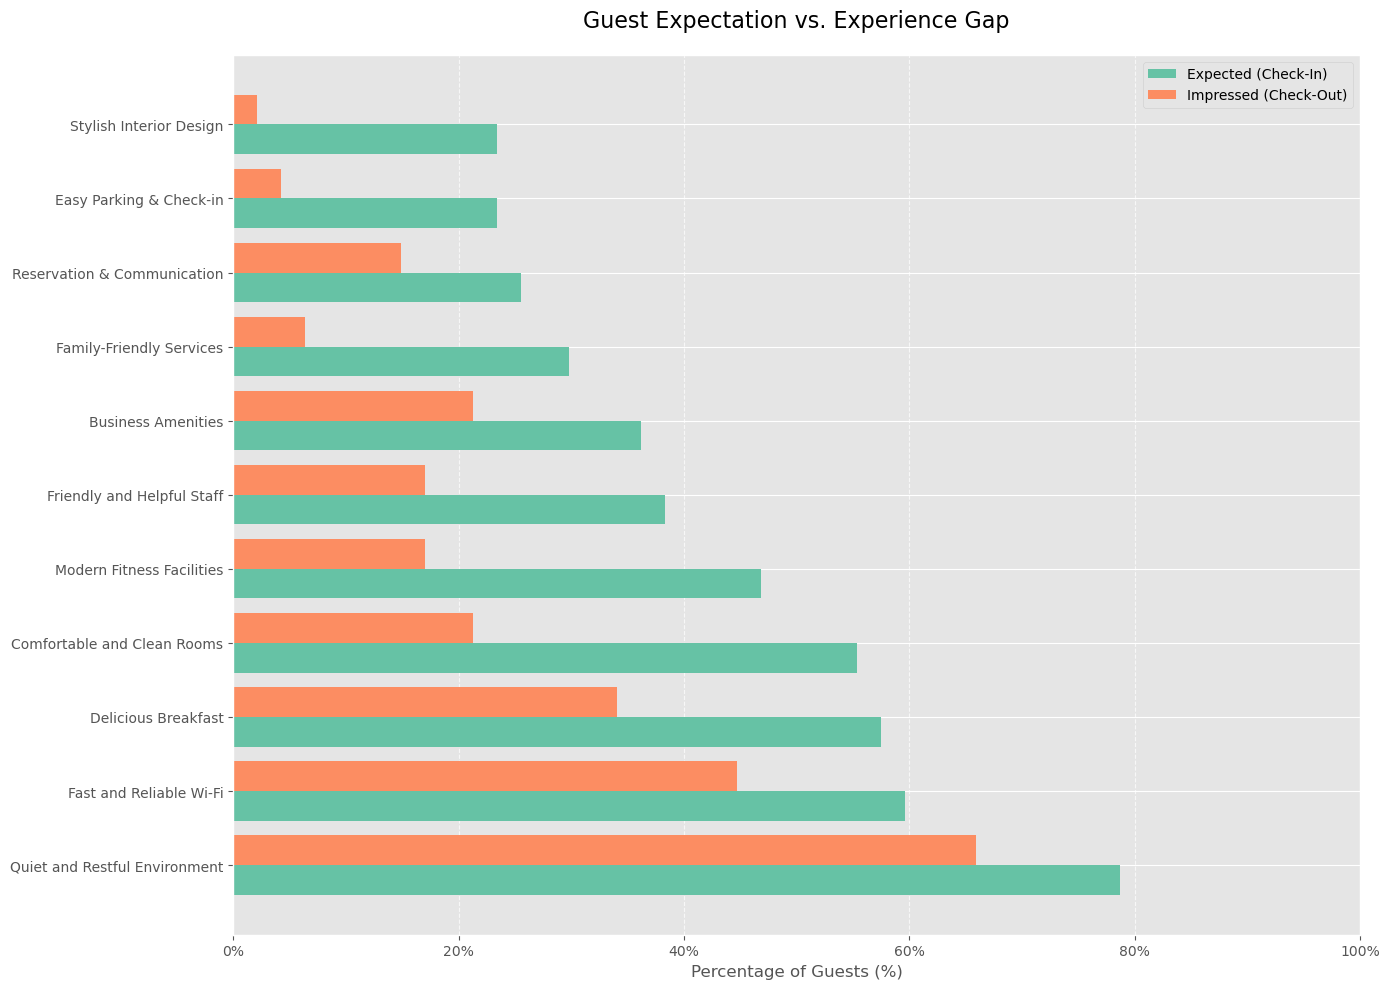


2. Plotting continuation rates...


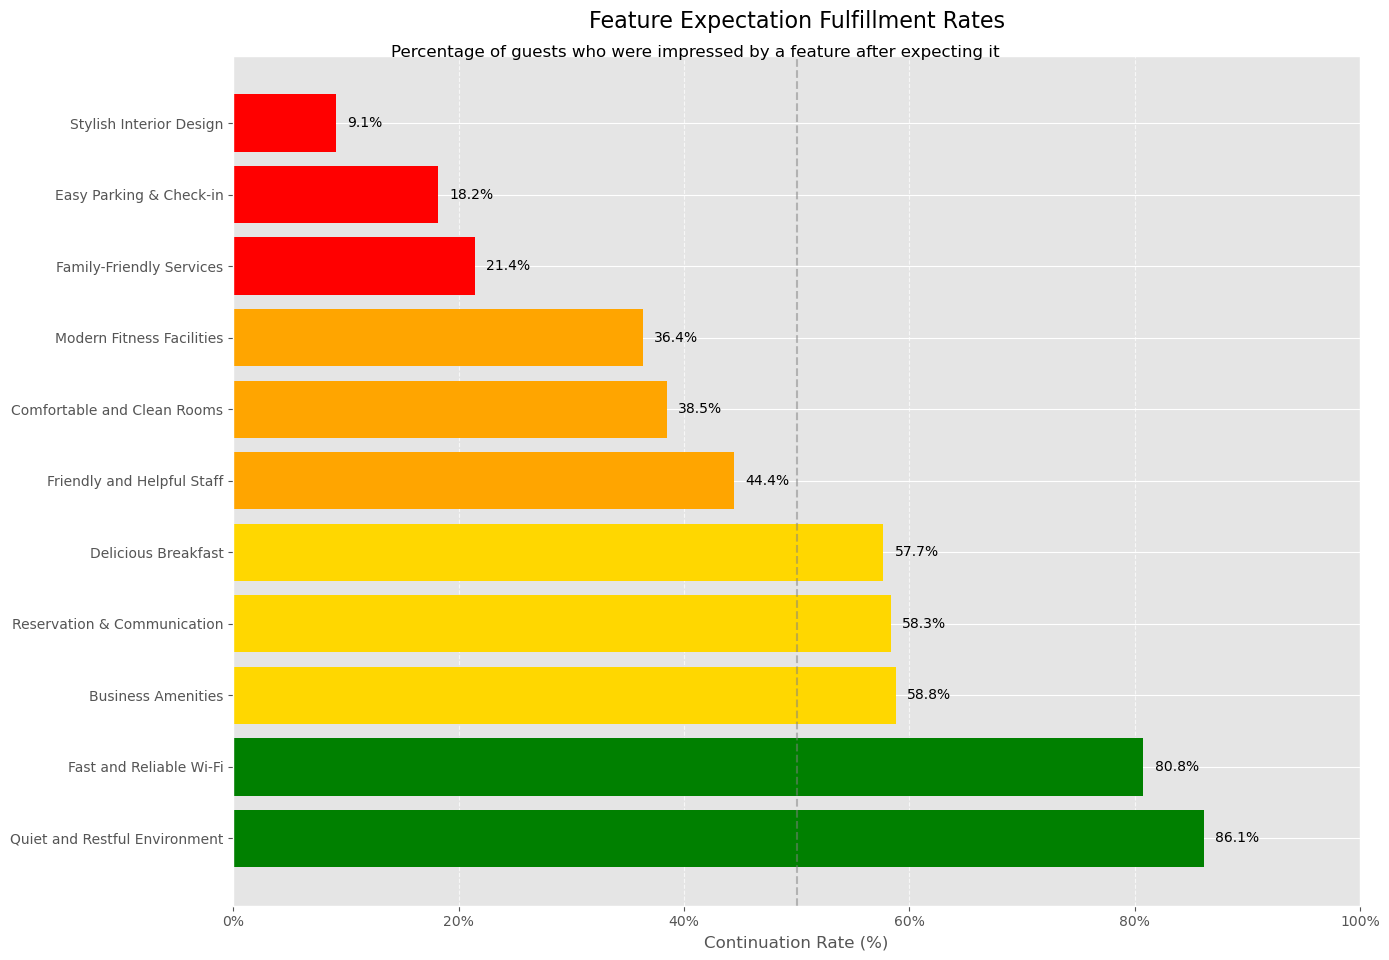


3. Plotting customer experience patterns...


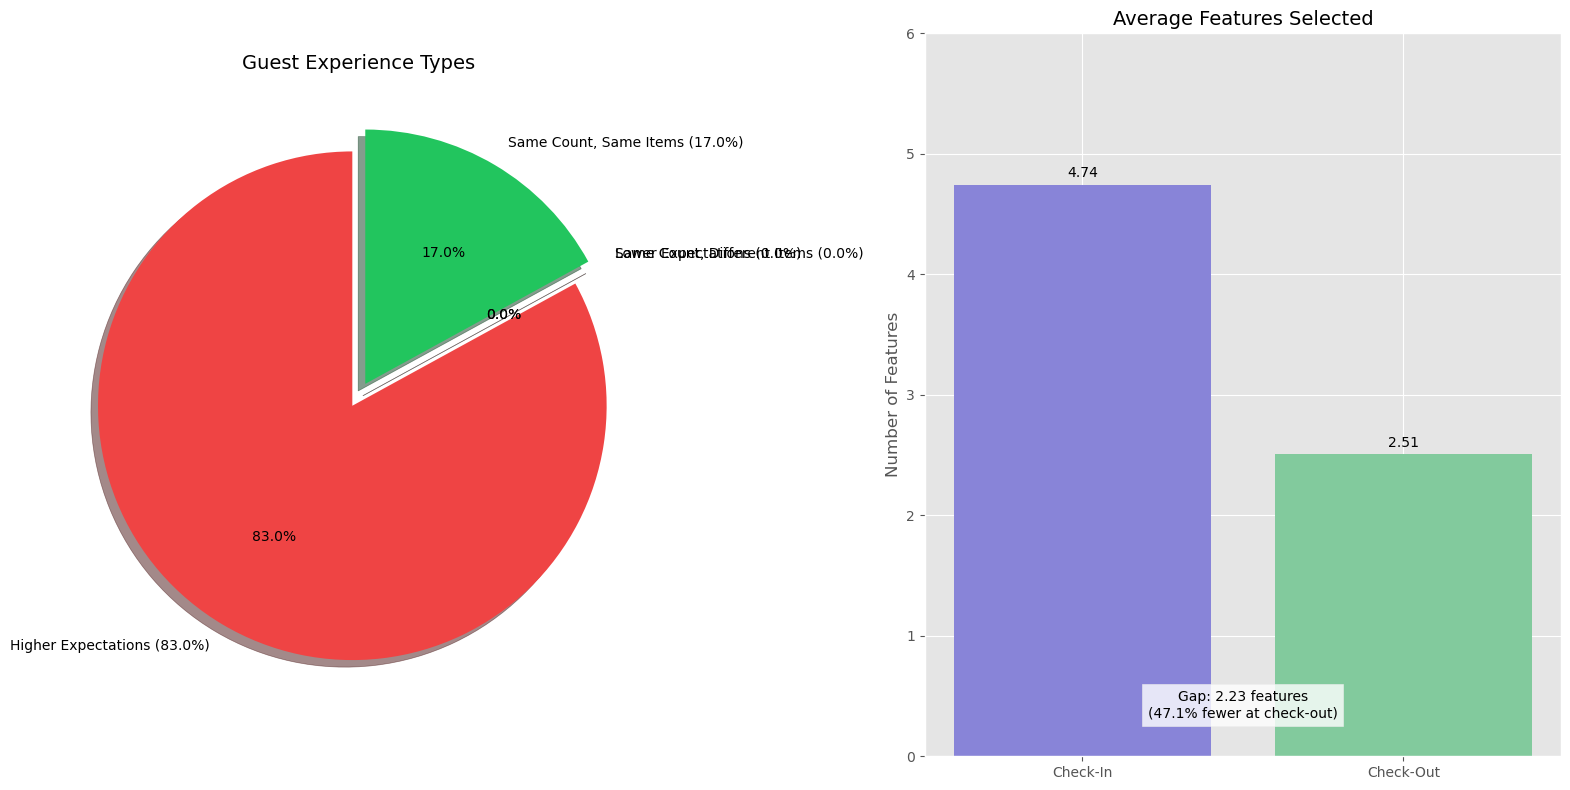


===== ANALYSIS COMPLETE =====
Three charts have been saved: expectation_gap_chart.png, continuation_rates_chart.png, and experience_patterns_chart.png

===== KEY INSIGHTS =====
1. Expectation-Experience Gap:
   - Comfortable and Clean Rooms: 34.0% gap (-34.0%)
   - Modern Fitness Facilities: 29.8% gap (-29.8%)
   - Delicious Breakfast: 23.4% gap (-23.4%)
   - Family-Friendly Services: 23.4% gap (-23.4%)
   - Friendly and Helpful Staff: 21.3% gap (-21.3%)

2. Feature Fulfillment:
   Most Reliable Features:
   - Quiet and Restful Environment: 86.1% continuation
   - Fast and Reliable Wi-Fi: 80.8% continuation
   Least Reliable Features:
   - Family-Friendly Services: 21.4% continuation
   - Easy Parking & Check-in: 18.2% continuation
   - Stylish Interior Design: 9.1% continuation

3. Customer Experience Patterns:
   - 39/47 guests (Higher Expectations (83.0%))
   - Average selections gap: 2.23 features
   - 47.1% fewer features selected at check-out


In [52]:
# If running the script directly
if __name__ == "__main__":
    # Replace with your actual file path
    file_path = "Raw_Data.xlsx"
    results = analyze_hotel_data(file_path)